In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline
import librosa
import utils
import ast

import pickle

import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape
from kapre.time_frequency import Melspectrogram
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler

In [2]:
features = pd.read_csv('data/features.csv', index_col=0, header=[0, 1, 2])
fma_single = pickle.load(open("saved/fma_single.p", "rb"))

In [3]:
fma_multi=pickle.load(open("saved/fma_multi.p","rb"))

In [4]:
fma_multi.head()

,split,subset,filepath,genres_all,genre_top
track_id,,,,,
2,training,small,data/fma_large/000/000002.mp3,[21],Hip-Hop
3,training,medium,data/fma_large/000/000003.mp3,[21],Hip-Hop
5,training,small,data/fma_large/000/000005.mp3,[21],Hip-Hop
10,training,small,data/fma_large/000/000010.mp3,[10],Pop
20,training,large,data/fma_large/000/000020.mp3,"[17, 10, 76, 103]",NaN


For the baseline model we are going to use the 'small' set of 8000 tracks in 8 classes, and train the model on the mfccs of the tracks which we extracted earlier.

In [5]:
#load mfccs
mfcc_df=pickle.load(open("saved/mfcc_small.p","rb"))

In [6]:
mfcc_df.shape

(7997, 23232)

In [7]:
mfcc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23222,23223,23224,23225,23226,23227,23228,23229,23230,23231
2,-299.542053,-202.513412,-159.976059,-115.456413,-80.415161,-67.523239,-57.689404,-65.464790,-84.703659,-96.179939,...,-5.861199,-4.460218,-6.887738,-7.665272,6.717929,12.769140,11.439809,9.167293,7.916427,5.665779
5,-324.059723,-227.421249,-186.883606,-158.489868,-94.902466,-95.517578,-106.146324,-70.498611,-45.091522,-41.156029,...,-6.403229,-4.675876,5.932048,19.163589,24.138350,12.146925,1.931949,-0.370714,1.137535,-0.625799
10,-71.376122,-32.296730,-29.356266,-38.037708,-44.881695,-45.910717,-31.081173,8.275231,28.077381,6.006516,...,9.814901,0.409050,-6.546686,-4.728213,-2.329597,4.121199,8.337200,8.429386,10.133602,11.033691
140,-561.324280,-523.545837,-449.814423,-342.445557,-306.727356,-308.809631,-307.733276,-317.345245,-362.774811,-419.306946,...,1.818927,3.912658,4.593844,2.139801,-4.394735,-5.267244,-6.697974,-5.783470,-5.886441,-3.706590
141,-464.980743,-371.434326,-330.917175,-342.813904,-362.013550,-368.364441,-361.755188,-358.438049,-365.668640,-375.685730,...,0.601643,-0.995060,0.146230,3.676285,-1.177926,-2.822582,4.884428,3.736303,2.701882,-2.805002


In [8]:
#use the 8000 track balanced subset for baseline modeling
subset = fma_single.index[fma_single['subset'] == 'small']
tracks_sub=fma_multi.loc[subset]
mfcc_sub=mfcc_df.loc[subset]


In [9]:
#fill nan
mfcc_sub.fillna(value=0,inplace=True)

In [10]:
print(len(mfcc_sub),len(tracks_sub))

7997 7997


In [11]:
#use the built in train/test/vavlidation split in case we want to compare to other models over this dataset
train = tracks_sub.index[tracks_sub['split'] == 'training']
val = tracks_sub.index[tracks_sub['split'] == 'validation']
test = tracks_sub.index[tracks_sub['split'] == 'test']

In [12]:
print(len(train),len(val),len(test))

6397 800 800


In [13]:
#preprocessing single label

#enc=MultiLabelBinarizer()
enc=LabelEncoder()
labels=tracks_sub['genre_top']
#labels=y_df

# Split in training, validation and testing sets.

#single label
y_train = enc.fit_transform(labels[train])
y_val = enc.transform(labels[val])
y_test = enc.transform(labels[test])
#y_train = track_sub['label']

X_train = mfcc_sub.loc[train].values
X_val = mfcc_sub.loc[val].values
X_test = mfcc_sub.loc[test].values
    
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Standardize features
scaler =StandardScaler(copy=False)
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

In [14]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               11895296  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 520       
Total params: 12,068,296
Trainable params: 12,068,296
Non-trainable params: 0
_________________________________________________________________


In [15]:
history=model.fit(X_train,
          y_train,
          epochs=20,
          batch_size=512,
          validation_data=(X_val, y_val))
results = model.evaluate(X_test, y_test)

Train on 6397 samples, validate on 800 samples
Epoch 1/20
6397/6397 [==============================] - 2s 350us/step - loss: 3.0683 - accuracy: 0.2683 - val_loss: 2.2378 - val_accuracy: 0.2875
Epoch 2/20
6397/6397 [==============================] - 2s 331us/step - loss: 1.7449 - accuracy: 0.4103 - val_loss: 2.0187 - val_accuracy: 0.3125
Epoch 3/20
6397/6397 [==============================] - 2s 332us/step - loss: 1.3378 - accuracy: 0.5514 - val_loss: 2.0702 - val_accuracy: 0.3113
Epoch 4/20
6397/6397 [==============================] - 2s 334us/step - loss: 1.0050 - accuracy: 0.6842 - val_loss: 1.9519 - val_accuracy: 0.3537
Epoch 5/20
6397/6397 [==============================] - 2s 331us/step - loss: 0.7106 - accuracy: 0.7963 - val_loss: 2.1068 - val_accuracy: 0.3475
Epoch 6/20
6397/6397 [==============================] - 2s 333us/step - loss: 0.5090 - accuracy: 0.8745 - val_loss: 2.3751 - val_accuracy: 0.2587
Epoch 7/20
6397/6397 [==============================] - 2s 335us/step - loss:

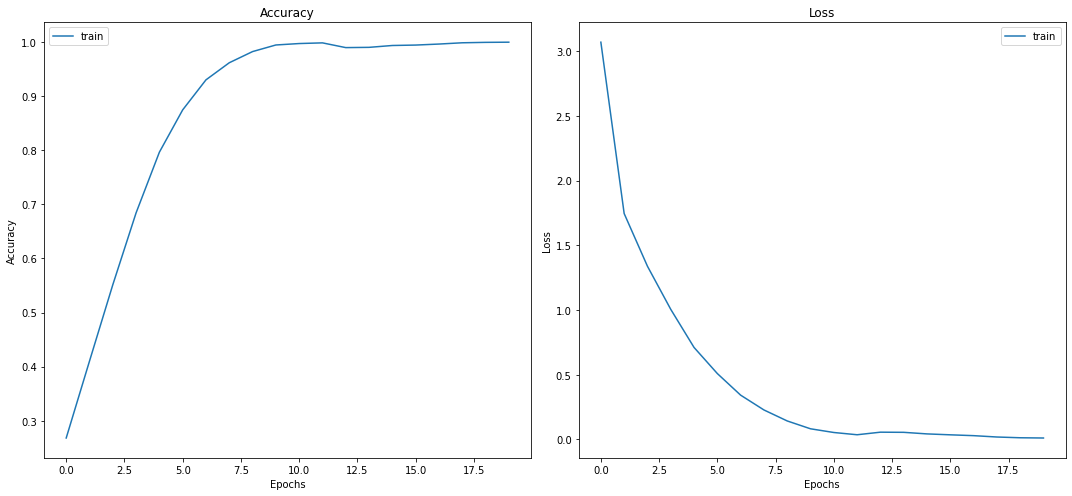

In [16]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
print('loss: ',results[0])
print('accuracy: ',results[1])

loss:  3.837606315612793
accuracy:  0.26374998688697815


In [20]:
#preprocessing multilabel

enc=MultiLabelBinarizer()
#enc=LabelEncoder()
labels=tracks_sub['genres_all'].map(ast.literal_eval)
#labels=y_df

# Split in training, validation and testing sets.

#single label
y_train = enc.fit_transform(labels[train])
y_val = enc.transform(labels[val])
y_test = enc.transform(labels[test])
#y_train = track_sub['label']

X_train = mfcc_sub.loc[train].values
X_val = mfcc_sub.loc[val].values
X_test = mfcc_sub.loc[test].values
    
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Standardize features
scaler =StandardScaler(copy=False)
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

In [26]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              23790592  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 114)               29298     
Total params: 24,476,018
Trainable params: 24,476,018
Non-trainable params: 0
_________________________________________________________________


In [29]:
history=model.fit(X_train,
          y_train,
          epochs=10,
          batch_size=256,
          validation_data=(X_val, y_val))
results = model.evaluate(X_test, y_test)

Train on 6397 samples, validate on 800 samples
Epoch 1/10
6397/6397 [==============================] - 5s 844us/step - loss: 712762819.7618 - accuracy: 0.0503 - val_loss: 1100517749.7600 - val_accuracy: 0.0025
Epoch 2/10
6397/6397 [==============================] - 6s 884us/step - loss: 1025129955.5267 - accuracy: 0.0355 - val_loss: 1617900810.2400 - val_accuracy: 0.1250
Epoch 3/10
6397/6397 [==============================] - 6s 875us/step - loss: 1520558939.8431 - accuracy: 0.0514 - val_loss: 2063561502.7200 - val_accuracy: 0.1250
Epoch 4/10
6397/6397 [==============================] - 6s 870us/step - loss: 2045767680.6003 - accuracy: 0.0549 - val_loss: 2398080245.7600 - val_accuracy: 0.1250
Epoch 5/10
6397/6397 [==============================] - 6s 879us/step - loss: 2561438956.8310 - accuracy: 0.0538 - val_loss: 3237202995.2000 - val_accuracy: 0.0000e+00
Epoch 6/10
6397/6397 [==============================] - 6s 879us/step - loss: 3107473080.6866 - accuracy: 0.0682 - val_loss: 38748

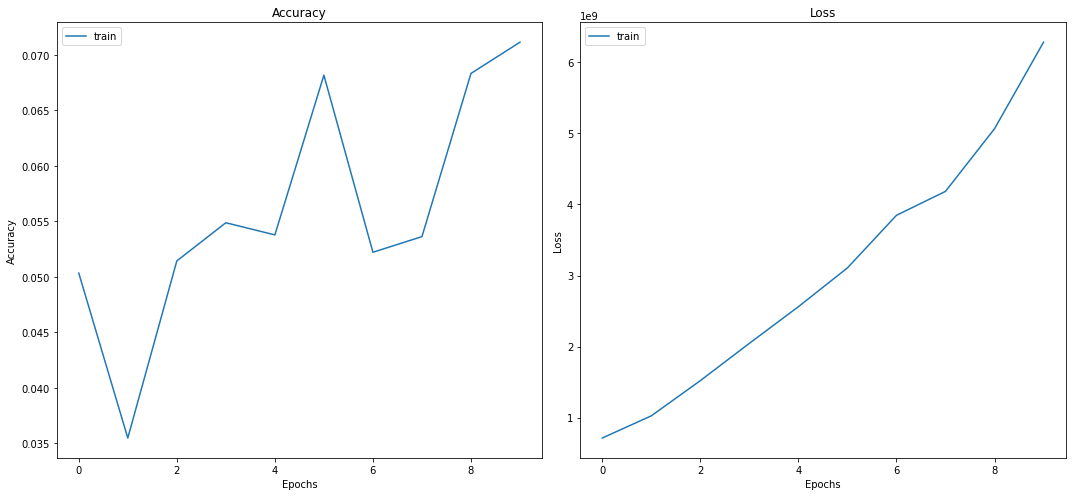

In [30]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
results

[5263209994.24, 0.0]

Over the reduced set of:  
* 8 classes
* 1000 samples each  

A baseline model of a fully connected neural net achieves 28% accuracy over the test set. We will extend this model using more current architectures.

In [ ]:
Over the same set, the multila

In [ ]:
test_hist=model.evaluate(x=X_test,
        y=y_test,
        batch_size=BS,
        verbose=1,
        sample_weight=None,
        steps=None,
        callbacks=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False
        
    )

In [ ]:
test_hist

In [ ]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Reshape((-1, 1), input_shape=(X_train.shape[1],)))
model.add(Conv1D(128, 512, activation="relu", strides=512))
model.add(Conv1D(32, 8, activation='relu'))
model.add(MaxPooling1D(4))
model.add(Conv1D(32, 8, activation='relu'))
model.add(MaxPooling1D(4))
#print(model.output_shape)
#model.add(Dropout(0.25))
#model.add(Flatten(input_shape=(0,0,32)))
#print(model.output_shape)
model.add(Dense(200, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))


#optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
optimizer=keras.optimizers.adam()
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
EPOCHS = 10
BS = 32
history=model.fit(
        x=X_train,
        y=y_train,
        batch_size=BS,
        epochs=EPOCHS,
        verbose=1,
        callbacks=None,
        validation_split=0.0,
        validation_data=(X_val,y_val),
        shuffle=True,        
        validation_freq=2,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=True
        )

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_hist=model.evaluate(x=X_test,
        y=y_test,
        batch_size=BS,
        verbose=1,
        sample_weight=None,
        steps=None,
        callbacks=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False
        
    )

In [ ]:
test_hist

In [ ]:
#from stanford
import numpy as np

from keras.models import Sequential
from my_classes import DataGenerator

# Parameters
params = {'dim': (32,32,32),
          'batch_size': 64,
          'n_classes': 6,
          'n_channels': 1,
          'shuffle': True}

# Datasets
partition = # IDs
labels = # Labels

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Design model
model = Sequential()
[...] # Architecture
model.compile()

# Train model on dataset
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6)

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#use loaded mfccs

# Split in training, validation and testing sets.
y_train = labels.loc[train].values
y_val = labels.loc[val].values
y_test = labels.loc[test].values
X_train = features_used.loc[train].values
X_val = features_used.loc[val].values
X_test = features_used.loc[test].values
    
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [ ]:
enc=MultiLabelBinarizer()

# Split in training, validation and testing sets.
y_train = enc.fit_transform(labels[train])
y_val = enc.transform(labels[val])
y_test = enc.transform(labels[test])
X_train = features_used.loc[train].values
X_val = features_used.loc[val].values
X_test = features_used.loc[test].values
    
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [ ]:
scaler = StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_val)
scaler.transform(X_test)

In [ ]:
X_train[0].shape

In [ ]:
import audioread


In [ ]:
#load all with librosa

#@jit(nopython=False)
def load_16k(dic):
    #SR=16000
    
    for idx,row in fma_tracks.iterrows():
        x,sr=librosa.load(row['filepath'],duration=10,dtype=np.int16)
        dic.update({idx:x})
    return dic

In [ ]:
X_dict={}
load_16k(X_dict)


In [ ]:
len(X_dict)

In [ ]:
audio_df=pd.DataFrame.from_dict(X_dict,orient='index')

In [ ]:
audio_df.shape

In [ ]:
pickle.dump(audio_df,open("saved/audio_df.p","wb"))

In [ ]:
ar=audioread.ffdec.FFmpegAudioFile('data/fma_large/000/000002.mp3')
ar.

In [ ]:
import decode
x=decode.decode('data/fma_large/000/000002.mp3')

For the baseline model, we will use the architecture of a convolutional neural net cited in the FMA repository

In [ ]:
x.shape

In [ ]:

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Dense(256, activation='relu',input_shape=(X_train.shape[0],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(Reshape((-1, 1), input_shape=(X_train.shape[1],)))
#model.add(Conv1D(128, 512, activation='relu', strides=512))
#model.add(Conv1D(32, 8, activation='relu'))
#model.add(MaxPooling1D(4))
#model.add(Conv1D(32, 8, activation='relu'))
#model.add(MaxPooling1D(4))
#model.add(Flatten())
#model.add(Dense(100, activation='relu'))
#model.add(Dense(labels_onehot.shape[1], activation='softmax'))
model.add(Dense(y_train.shape[1], activation='softmax'))


#optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
optimizer=keras.optimizers.adam()
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
EPOCHS = 30
BS = 16
history=model.fit(X_train,y_train, epochs=EPOCHS, batch_size=BS)

In [ ]:
datagen=ImageDataGenerator.flow_from_dataframe(
    dataframe=fma_tracks,
    directory=None,
    x_col="filepath",
    y_col="label",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="sparse",
    batch_size=32,
    shuffle=True,
    seed=42,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=False,
    #**kwargs
)

In [ ]:
br=22050
l=30
n=8000
br*n*l